# Исследование данных о продажах компьютерных игр

***Описание и цели проекта***

С целью выявления закономерностей и факторов, которые определяют успешнось компьютерной игры и позволят сделать ставку на потенциально популярный продукт, а также спланировать рекламные кампании, изучим доступные из открытых источников следующие исторические данные:

- название игры
- платформа
- год выпуска
- жанр игры
- продажи в Северной Америке (миллионы проданных копий)
- продажи в Европе (миллионы проданных копий)
- продажи в Японии (миллионы проданных копий)
- продажи в других странах (миллионы проданных копий)
- оценка критиков (максимум 100)
- оценка пользователей (максимум 10)
- рейтинг от организации ESRB (англ. Entertainment Software Rating Board)
    
На основаниии указанных данных с целью выявления тенденций и закономерностей на рынке компьютерных игр:
1. Изучим исходный датафрейм и выполним предобработку для дальнейшего анализа: проверим наличие пропусков, дубликатов и определим типы данных, при необхолимодимости обработаем их.
2. Проведем исследовательский анализ данных: выберем период времени для анализа, наиболее показательный для составления прогноза на 2017 год и, ограничившись указанным периодом, рассмотрим:
    - лидирующие по продажам платформы
    - распределение продаж игр в разбивке по платформам
    - влияние отзывов пользователей и критиков на продажи
    - распределение игр по жанрам и их продажи
3. Расммотрим портрет пользователя в Серевной Америке, Европе и Японии и выявим их предпочтения:
    - по платформам (топ-5)
    - по жанрам (топ-5)
    - по играм в зависимости от возрастного рейтинга ESRB
4. Проверим ряд гипотез

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as st

## Загрузка данных

In [2]:
# Загрузим  данные и выведем основную информацию
data = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [3]:
# Выведем первые строки датасета
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
# Сохораним количества строк в переменную для контроля объема удалояемых данных
data_rows = data.shape[0]
data_rows

16715

## Предобработка данных

In [5]:
# Приведем названия столбцов к нижнему регистру
data.columns = data.columns.str.lower()
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Перед тем, как менять формат данных, обозначим, что рейтинг пользователей 'tbd' - 'to be determined' означает, что рейтинг пользователей еще не был установлен. Причиной может быть, например, недостаточное количество отзывов о данной игре для того, чтобы считать оценку валидной, поэтому при изменении формата данных столбца с оценкой пользователей используем параметр errors = 'coerce', который заменит все 'tbd' на NaN.

In [6]:
# Изменим тип данных в столбце с годом выпуска на 'int', т.к. он не может быть дробным
data['year_of_release'] = data['year_of_release'].astype('Int64')

# Изменим тип данных в столбце с оценкой пользователей на 'float', т.к. оценка - числовое вещественное значение
data['user_score'] = pd.to_numeric(data['user_score'],errors = 'coerce')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.4+ MB


In [7]:
# Посчитаем процент пропущенных значений в каждом из столбцов
(data.isna().sum()/data.shape[0]*100).round(2).sort_values(ascending = False)

user_score         54.59
critic_score       51.32
rating             40.48
year_of_release     1.61
name                0.01
genre               0.01
platform            0.00
na_sales            0.00
eu_sales            0.00
jp_sales            0.00
other_sales         0.00
dtype: float64

In [8]:
# Удалим строки, в которых пропущено название игры, т.к. это ключевой параметр
data = data.dropna(subset = ['name'])

# Оценим долю удаленных данных 
print(f'Удалено {round((1 - data.shape[0]/data_rows)*100,2)} % данных')

# Убедимся, что пропуски в столбце с жанром также были удалены
print()
data.info()

Удалено 0.01 % данных

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.5+ MB


In [9]:
# Оставим пропуски в столбце с датой релиза, т.к. мы не можем восстановить год выпуска по названию игры, 
# потому что он может различаться для разных платформ, например, для игры "SimCity 2000":
data.query('name == "SimCity 2000"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
769,SimCity 2000,PC,1992,Simulation,1.20,0.84,0.00,0.10,NaN,NaN,NaN
1646,SimCity 2000,PS,1996,Simulation,0.68,0.46,0.00,0.08,NaN,NaN,NaN
4066,SimCity 2000,SNES,1995,Simulation,0.00,0.00,0.49,0.00,NaN,NaN,NaN
6219,SimCity 2000,SAT,1994,Simulation,0.00,0.00,0.28,0.00,NaN,NaN,NaN
10408,SimCity 2000,GBA,2003,Simulation,0.08,0.03,0.00,0.00,62.0,7.8,E


In [10]:
# Заменим пропуски в столбце 'rating' значением 'unknown', чтобы использовать его при составлении портрета пользователя

data['rating'] = data['rating'].fillna('unknown')

Оставим пропуски в столбцах с оценками критиков и пользователей, т.к. мы не можем их восстановить - рейтинг одной игры на разных платформах может отличаться, а удаление пропусков приведет к потере более чем половины данных.

Пропуски названия игры, года выпуска, жанра могут возникать по техническим причинам, например, ошибка загрузки из внешних источников, в то время как отсутствие рейтингов может быть связано с тем, что отзывы (критиков, пользователей) отсутствуют или их еще недостаточно для оценки (например, если игра вышла недавно или наблюдается низкий уровень продаж), а также отсутствует оценка ESRB по тем же причинам.

In [11]:
# Посчитаем количество полных явных дубликатов
f'Количество дубликатов {data.duplicated().sum()}'

'Количество дубликатов 0'

In [12]:
# Посчтаемый суммарный объем продаж во всех регионах
data.insert(8, 'total_sales', data[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis = 1))

## Исследовательский анализ данных

In [13]:
# Определим, сколько игр выпускалось в разные годы
data_game_per_year = (data
                      .pivot_table(index = 'year_of_release', values = 'name', aggfunc = 'count')
                      .rename(columns = {'name': 'Количество игр'})
                     )
data_game_per_year

,Количество игр
year_of_release,
1980,9
1981,46
1982,36
1983,17
1984,14
1985,14
1986,21
1987,16
1988,15


<Figure size 1500x500 with 0 Axes>

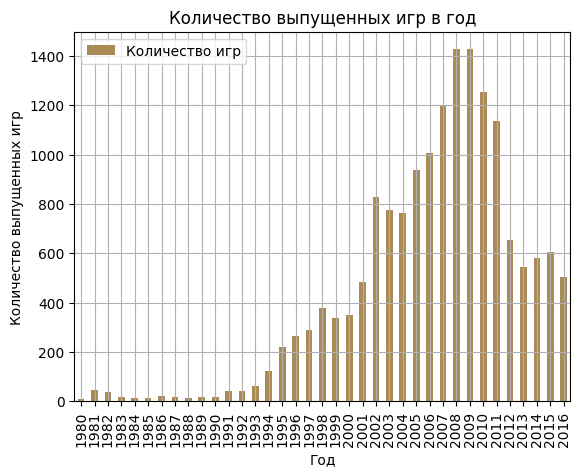

In [14]:
# Визуализируем динамику выпуска игр
plt.figure(figsize = (15,5)) 
ax = data_game_per_year.plot(kind = 'bar', grid = True, color = '#AA8B56')
ax.set_ylabel('Количество выпущенных игр')
ax.set_xlabel('Год')
ax.set_title('Количество выпущенных игр в год')
plt.show()

Согласно приведенным данным в период до 1994 года выпускалось менее 100 игр в год, а на уровень, который сопоставим с современным выпуски игр вышли после 2000 года. Пиковое значение выпало на 2008 - 2009 гг., а после 2011 г. количество выпускаемых игр значительно упало и остается на относительно низком уровне по состоянию на 2016 г. Вероятно, нецелесообразно анализировать данные за все годы, т.к. выпущенные 30 лет назад игры могут могут быть недоступны на современных устройствах, не могут составить конкуренцию с техноголической точки зрения современным продуктам и, соответственно, не могут быть предметом массового потребления, кроме того, они выходили в период низкой конкуренции на рынке, соответственно, нет смысла их учитывать при планировании продаж на 2017 год.

In [15]:
# Выберем платформы с наибольшими суммарными продажами и построим распределение по годам
platform_max_sales = (data
                      .pivot_table(index = 'platform', values = 'total_sales', aggfunc = 'sum')
                      .sort_values(by = 'total_sales', ascending = False)
                      .reset_index()
                      .head(6)
                     )
platform_max_sales

,platform,total_sales
0,PS2,1255.77
1,X360,971.42
2,PS3,939.65
3,Wii,907.51
4,DS,806.12
5,PS,730.86


Самые большие объемы продаж (около 1000 млн. копий) показали платформы PS2, X360, PS3, Wii, DS, PS

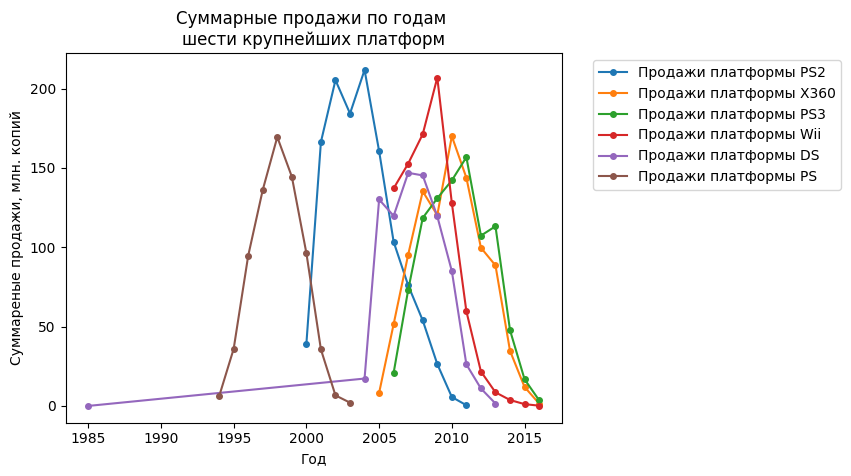

In [16]:
# Построим распределение продаж по годам выпущенных игр для платформ из топ-6 по суммарным продажам
for p in platform_max_sales['platform']:
    data_platform = data.query('platform == @p').pivot_table(index = 'year_of_release', values = 'total_sales', aggfunc = 'sum').reset_index()
    plt.plot(data_platform['year_of_release'], data_platform['total_sales'], label = f'Продажи платформы {p}', marker = 'o', markersize = 4)
plt.legend(bbox_to_anchor=(1.05,1), ncol = 1)
plt.xlabel('Год')
plt.ylabel('Суммареные продажи, млн. копий')
plt.title('Суммарные продажи по годам \nшести крупнейших платформ') 
plt.show()

Согласно графику, цикл платформы составляет около 10 лет, после чего она сменяется новой платформой, с учетом этого, а также динамики выпусков игр по годам, которая показывает падение после 2011 года, имеет смысл ограничить рассматриваемый период. Далее будем рассматривать период половины цикла с 2012 по 2016 год. 

In [17]:
# Ограничим данные периодом с 2012 по 2016 год
data_new = data.query('year_of_release >= 2012')

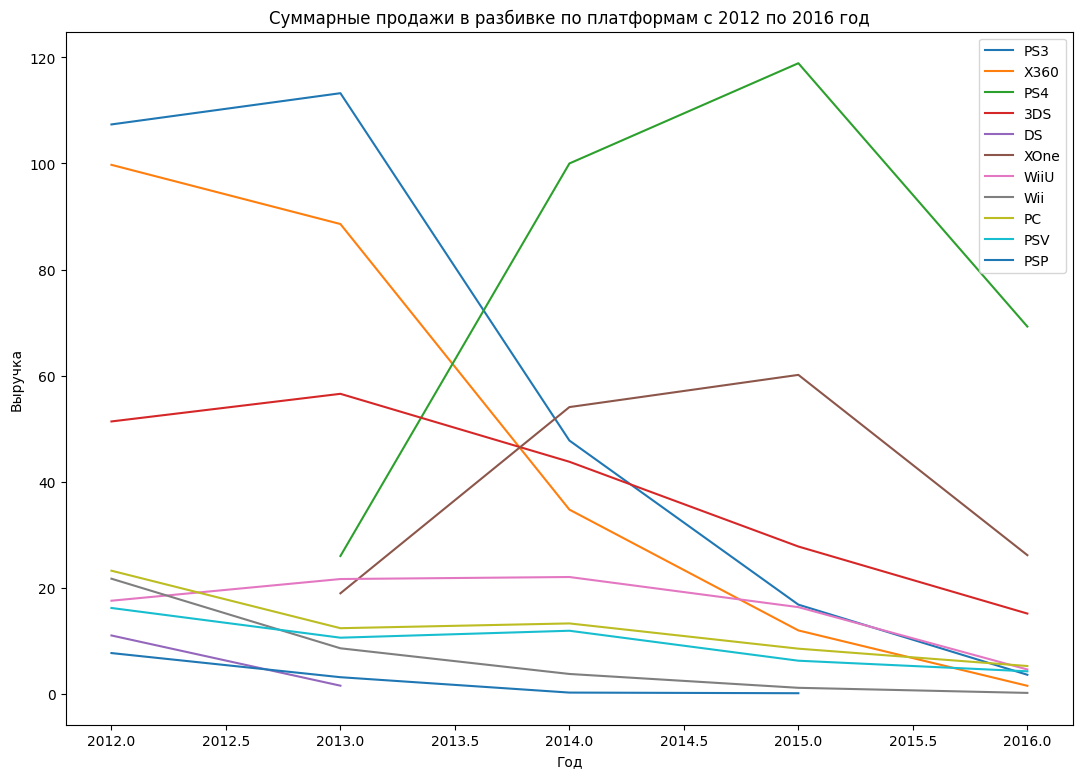

In [18]:
# Оценим, динамику продаж различных платформ
plt.figure(figsize = (13, 9))
for p in data_new['platform'].unique():
    data_platform_new = data_new.query('platform == @p').pivot_table(index = 'year_of_release', values = 'total_sales', aggfunc = 'sum').reset_index()
    plt.plot(data_platform_new['year_of_release'], data_platform_new['total_sales'], label = f'{p}')
plt.legend()
plt.xlabel('Год')
plt.ylabel('Выручка')
plt.title('Суммарные продажи в разбивке по платформам с 2012 по 2016 год') 
plt.show()

На протяжении рассматриваемого периода времени наибольший уровень продаж показывали X360, PS3, однако продажи рассматриваемых платформ, включая X360, PS3 падают в последние годы рассматриваемого периода, что подтверждается ранее построенной гистограммой. При этом новые пдлатфоромы PS4 и XOne, появившиеся в 2013 году имеют лучшие показатели продаж среди конкурентов в последние два года рассматриваемого периода. Кроме того, следует учитывать, что данные в 2016 году приведены за неполный год и могут показать более высокое итоговое значение.

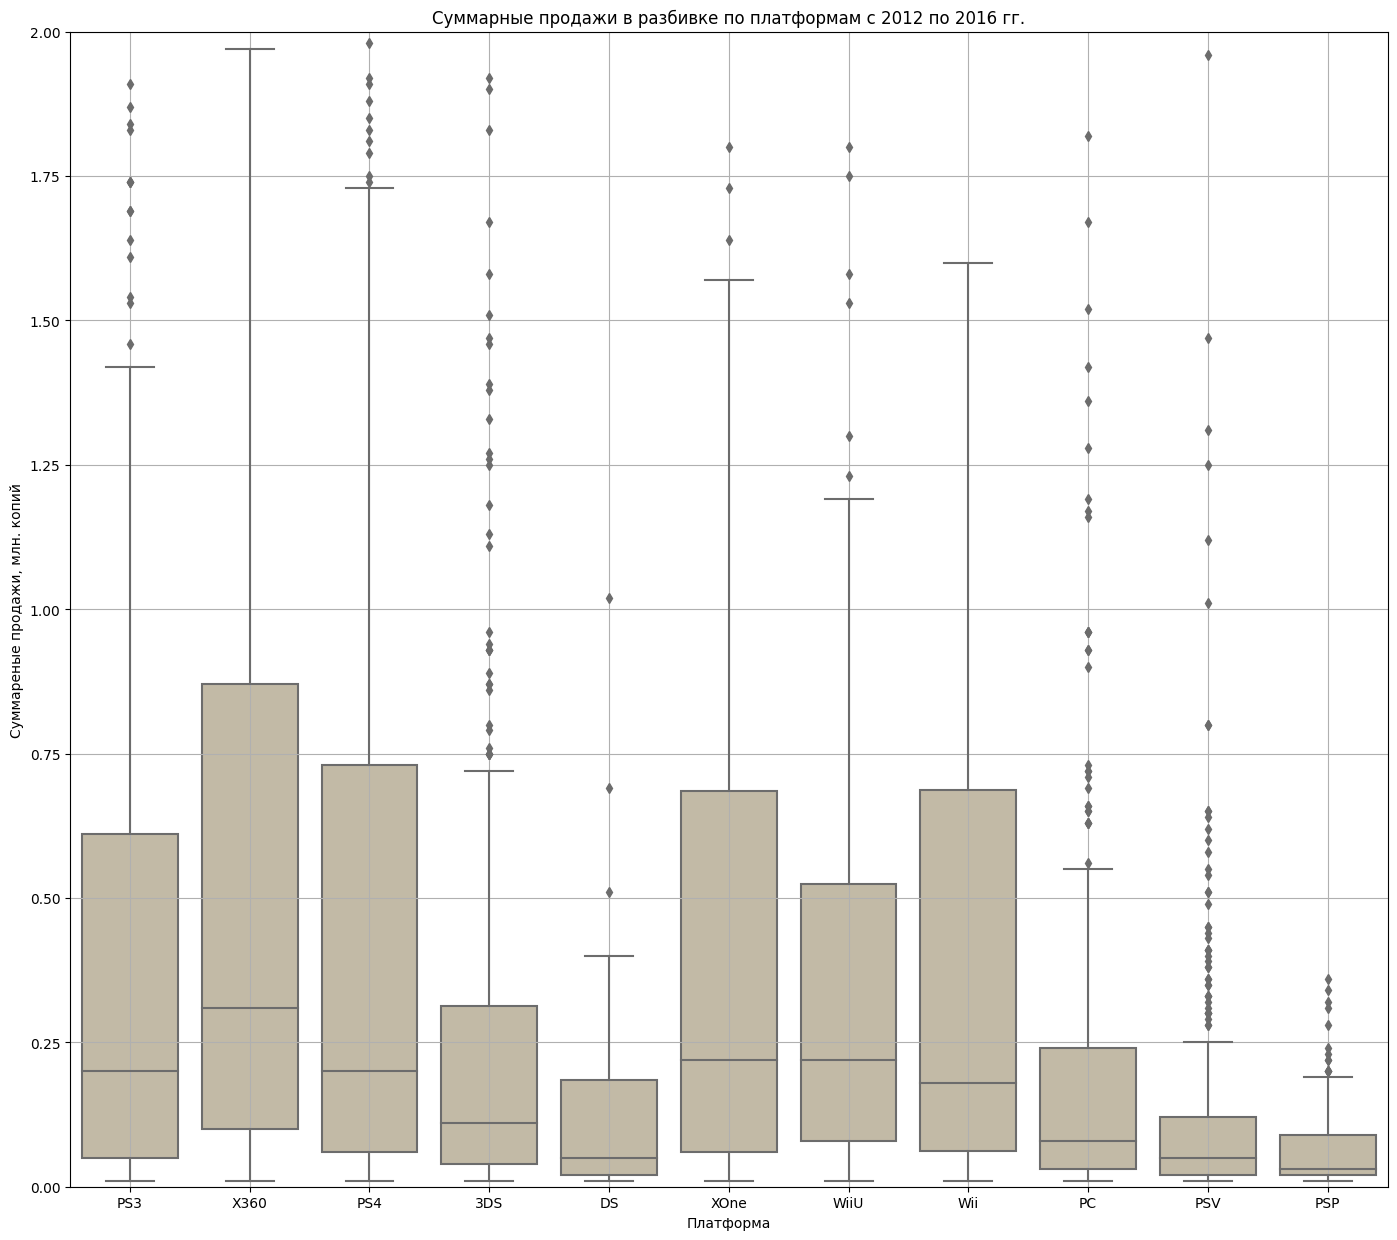

In [19]:
# Построим диаграмму размаха по глобальным продажам игр в разбивке по платформам
plt.figure(figsize = (17, 15))
platform_boxplot = sns.boxplot(x = 'platform', y = 'total_sales', data = data_new, color = '#C7BCA1') 
platform_boxplot.set_ylim([0, 2])
plt.grid()
plt.xlabel('Платформа')
plt.ylabel('Суммареные продажи, млн. копий')
plt.title('Суммарные продажи в разбивке по платформам с 2012 по 2016 гг.') 
plt.show()

Ограничив ось y продажами в 2 млн. копий, мы можем видеть более детально распределение продаж одной игры для каждой из платформ - все они имеют выбросы, превышающие 1,5 межквартильного размаха от 3го квартиля, при этом медианное значение продаж составляет менее 250 тыс копий для всех платформ, кроме X360 (которая немного превысила указанную планку) и стремится к нижней границе значений. Т.е. для подавляющего большинства платформ более 50 % игр проданы в количестве менее 250 тыс. копий, а 75% - менее 750 тыс. копий, при этом выбросы говорят о том, что у каждой платформы есть игры-звезды, которые показали уровень продаж, существенно превышающий уровень, характерный для большинства игр данной платформы. В целом, наиболее успешно с точки зрения продаж себя показали X360, PS4, XOne, Wii и PS3.

Коэффициент корреляции Пирсона для оценки критиков и объемом продаж платформы X360 составляет: 0.36


'Коэффициент корреляции Пирсона для оценки пользователей и объемом продаж платформы X360 составляет: 0.01'

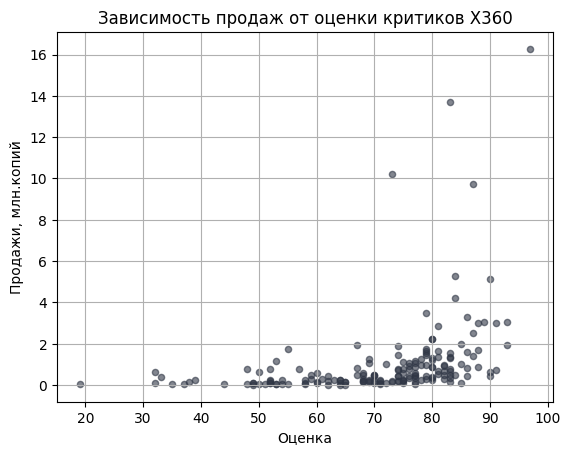

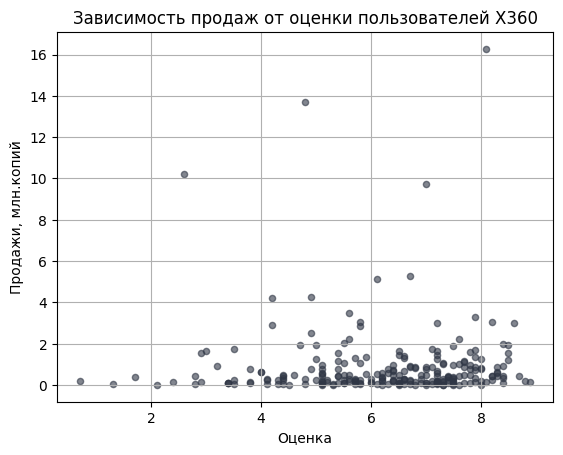

In [20]:
# Определим, как влияют на продажи внутри одной платформы отзывы пользователей и критиков. 
# Рассмотрим на примере популярной платформы X360.

# Создадим функцию для построения диаграммы рессеяния
def get_scatter(dataset, score_type):
    dataset.plot(
    x = score_type, 
    y = 'total_sales', 
    kind = 'scatter', 
    alpha = 0.6, 
    grid=True, 
    legend = True, 
    xlabel = 'Оценка', 
    ylabel = 'Продажи, млн.копий', 
    color = '#2F3645'
)
# Создадим функцию для расчета коэффициента Пирсона
def get_pirson(data, score_type):
    data[score_type].corr(data['total_sales']).round(2)

#Зависимость между оценкой критиков и объемом продаж платформы X360

platform_x = data_new.query('platform == "X360"')

get_scatter(platform_x, 'critic_score')
plt.title('Зависимость продаж от оценки критиков X360')

p_critic = platform_x['critic_score'].corr(platform_x['total_sales']).round(2)

#Зависимость между оценкой пользователей и объемом продаж платформы X360

get_scatter(platform_x, 'user_score')
plt.title('Зависимость продаж от оценки пользователей X360')

p_user = platform_x['user_score'].corr(platform_x['total_sales']).round(2)

print(f'Коэффициент корреляции Пирсона для оценки критиков и объемом продаж платформы X360 составляет: {p_critic}')
f'Коэффициент корреляции Пирсона для оценки пользователей и объемом продаж платформы X360 составляет: {p_user}'

Между оценкой критиков и продажами игр на платформе X360 существует прямая зависимость, однако эту зависимость нельзя назвать сильной - коэффициент корреляции Пирсона составляет 0,36. Очень незначительная связь у продаж и оценкой пользователей 0, 01, можно сказать, что связь отсутствует. Причиной может быть как существенное влияние иных факторов или недостаточное количество оценок для того, чтобы они были плоказательны.

Коэффициент корреляции Пирсона для оценки критиков и объемом продаж платформы PS4 составляет: 0.41


'Коэффициент корреляции Пирсона для оценки пользователей и объемом продаж платформы PS4 составляет: -0.03'

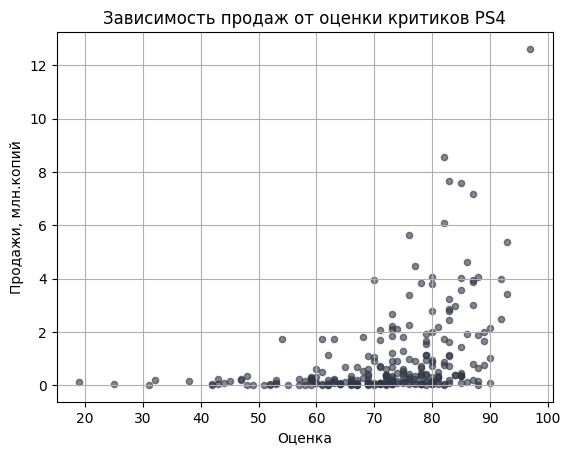

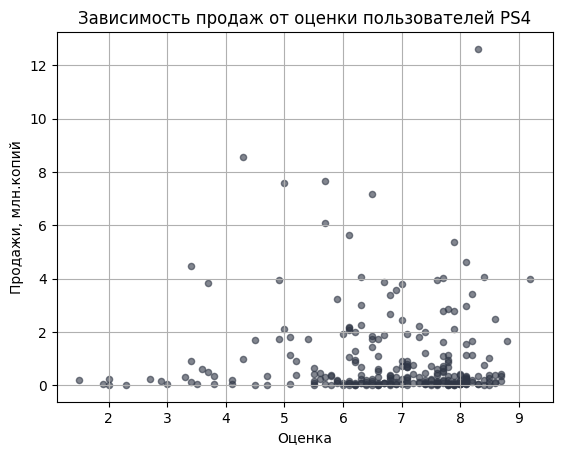

In [21]:
# Проверим, подтверждаются ли эти выводы продажами на двух других популярных платформах, выпущенных другими корпорациями,
# построив диаграмму рассеяния и посчитав корреляцию
# Рассмотрим на примере платформы PS4.

platform_ps = data_new.query('platform == "PS4"')

#Зависимость между оценкой критиков и объемом продаж

get_scatter(platform_ps, 'critic_score')
plt.title('Зависимость продаж от оценки критиков PS4')

p_critic_ps = platform_ps['critic_score'].corr(platform_ps['total_sales']).round(2)

#Зависимость между оценкой пользователей и объемом продаж

get_scatter(platform_ps, 'user_score')
plt.title('Зависимость продаж от оценки пользователей PS4')

p_user_ps = platform_ps['user_score'].corr(platform_ps['total_sales']).round(2)

print(f'Коэффициент корреляции Пирсона для оценки критиков и объемом продаж платформы PS4 составляет: {p_critic_ps}')
f'Коэффициент корреляции Пирсона для оценки пользователей и объемом продаж платформы PS4 составляет: {p_user_ps}'

Корреляция между оценкой (критиков и пользователей) и продажами игр на платформе PS4 похожа на зависимость, установленную для X360 - относительно низкая прямая корреляция с отзывами критиков и отрицательная корреляция на уровне ее отсутствия с отзывами пользователей.

Коэффициент корреляции Пирсона для оценки критиков и объемом продаж платформы 3DS составляет: 0.32


'Коэффициент корреляции Пирсона для оценки пользователей и объемом продаж платформы 3DS составляет: 0.2'

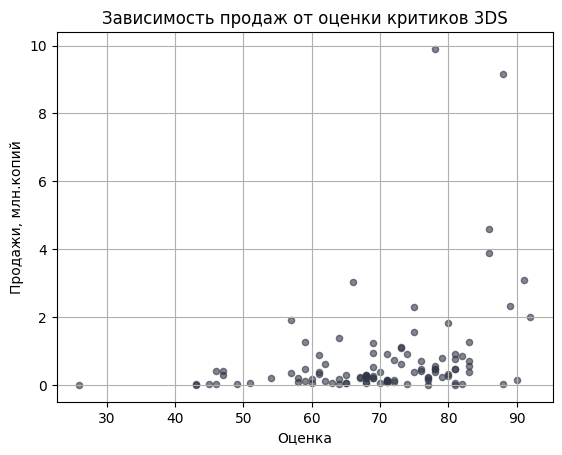

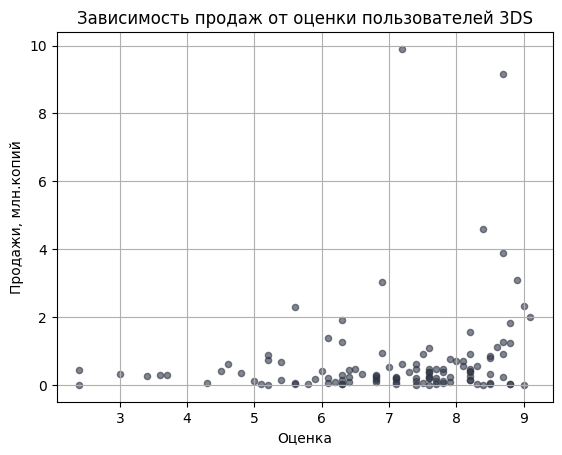

In [22]:
# Рассмотрим на примере платформы 3DS.

platform_ds = data_new.query('platform == "3DS"')

#Зависимость между оценкой критиков и объемом продаж

get_scatter(platform_ds, 'critic_score')
plt.title('Зависимость продаж от оценки критиков 3DS')

p_critic_ds = platform_ds['critic_score'].corr(platform_ds['total_sales']).round(2)

#Зависимость между оценкой пользователей и объемом продаж

get_scatter(platform_ds, 'user_score')
plt.title('Зависимость продаж от оценки пользователей 3DS')

p_user_ds = platform_ds['user_score'].corr(platform_ds['total_sales']).round(2)

print(f'Коэффициент корреляции Пирсона для оценки критиков и объемом продаж платформы 3DS составляет: {p_critic_ds}')
f'Коэффициент корреляции Пирсона для оценки пользователей и объемом продаж платформы 3DS составляет: {p_user_ds}'

Для платформы 3DS уровень корреляции оценки критиков с продажами аналогичен предыдущим рассмотренным платформам, однако корреляция оценки пользователей с продажами сильнее - коэффициент Пирсона 0,2, однако такую прямую зависимость все еще нельзя назвать сильной.   

В целом, все три рассмотренные платформы показали слабый уровень корреляции оценки критиков и пользователей с уровнем продаж.

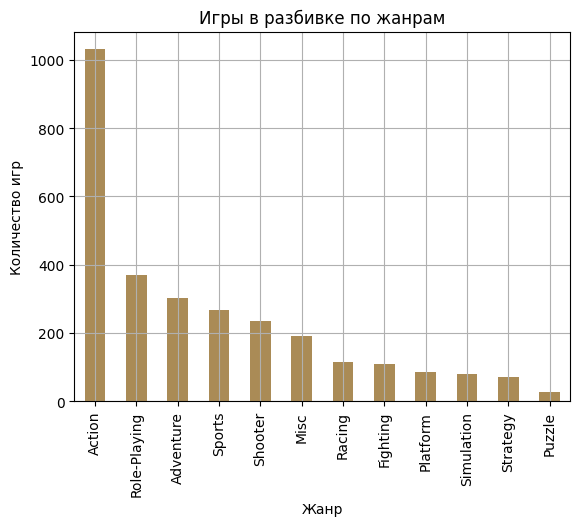

In [23]:
# Рассмотрим распредление игр по жанрам

genre_plot = (data_new.groupby('genre')['total_sales']
              .count().sort_values(ascending = False)
              .plot(kind = 'bar', grid = True, color = '#AA8B56')
             )
genre_plot.set_ylabel('Количество игр')
genre_plot.set_xlabel('Жанр')
genre_plot.set_title('Игры в разбивке по жанрам')
plt.show()

Больше всего игр за рассматриваемый период представлены в жанре экшн, далее в поряядке убывания с большим отрывом от лидера - ролевые игры, меньше всего представлены стратегии и головоломки.

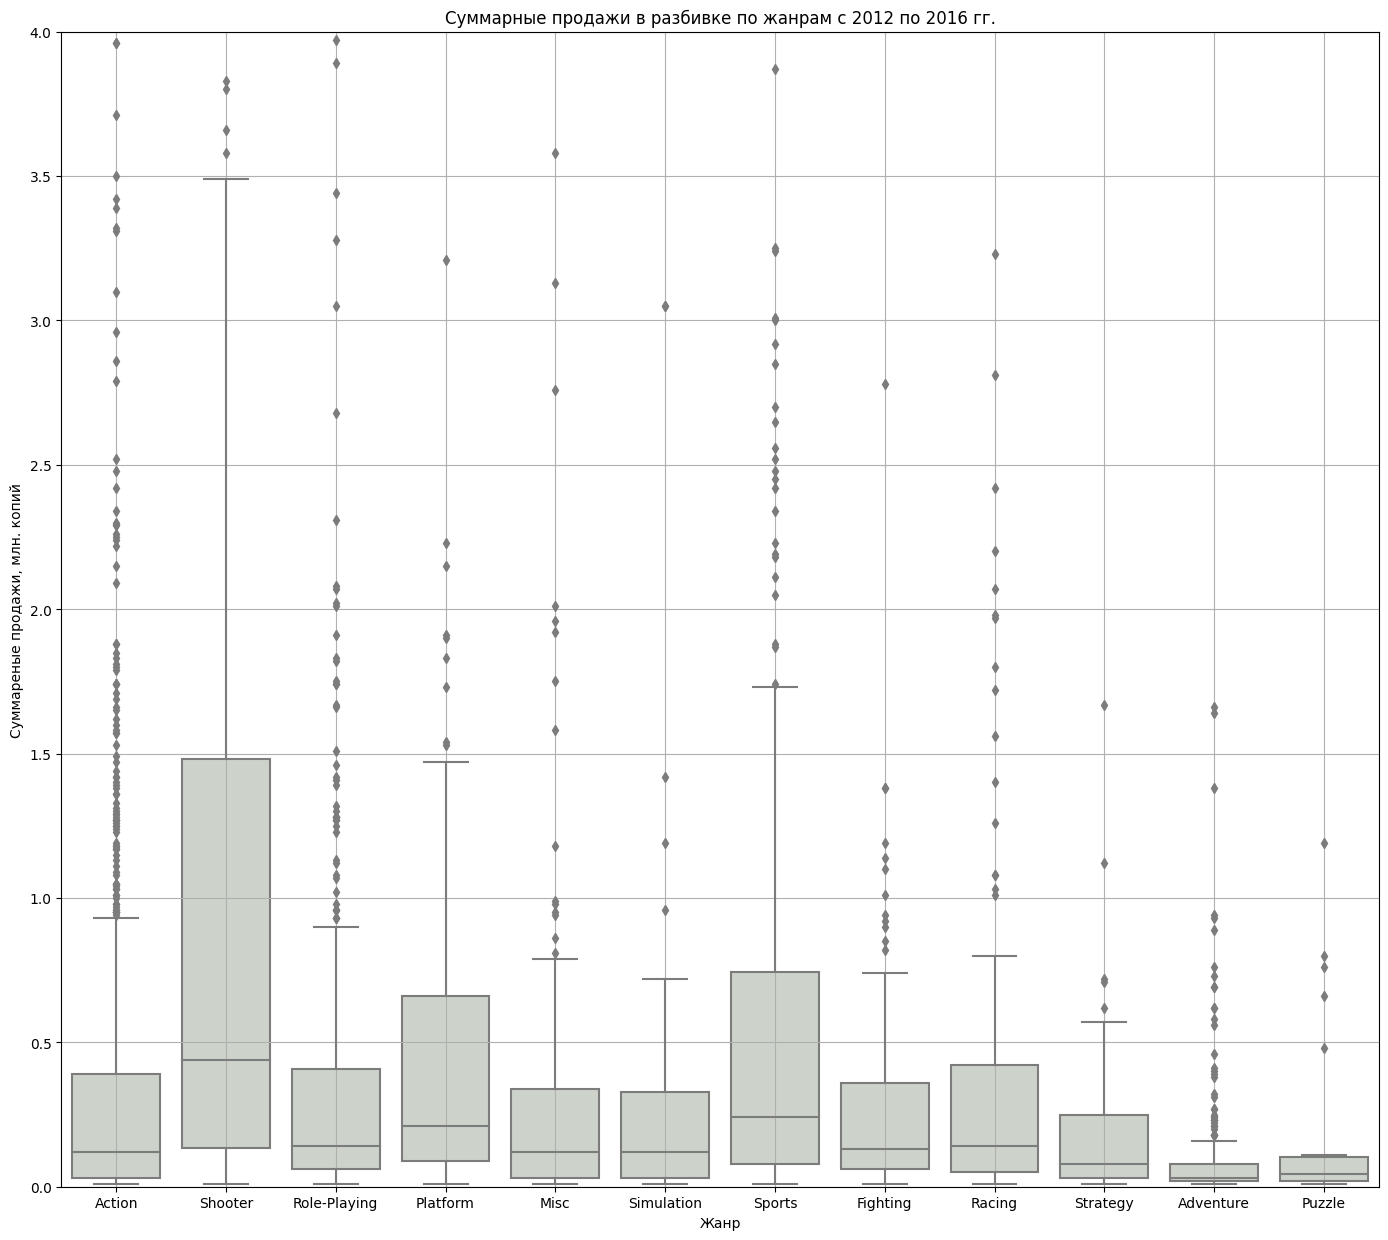

In [24]:
# Рассмотрим распредление продаж по жанрам

# Построим диаграмму размаха по глобальным продажам игр в разбивке по жанрам
plt.figure(figsize = (17, 15))
genre_boxplot = sns.boxplot(x = 'genre', y = 'total_sales', data = data_new, color = '#CCD3CA') 
genre_boxplot.set_ylim([0, 4])
plt.grid()
plt.xlabel('Жанр')
plt.ylabel('Суммареные продажи, млн. копий')
plt.title('Суммарные продажи в разбивке по жанрам с 2012 по 2016 гг.') 
plt.show()

Несмотря на то, что по количеству представленных игр наиболее популярны игры в жанре экшн, наиболее прибыльным являются игры в жанре шутер. Медианное значение продаж одной игры в жанре шутер больше, чем у других жанров и близко к значению 500 тыс копий, кроме того шутеры имеют большой межквартильный размах и небольшое количество выбросов в сравнении с другими жанрами. Также среди по медианному значению продаж олной игры - спортивные игры и платформеры. Игры в жанре экшн, несмотря на их преобладание на рынке, имеют средний уровень прибыльности наравне с ролевыми играми, симуляторами, смешанными жанрами, файтингами и гонками.

## Портрет пользователя

In [25]:
def get_top_platforms(region_sales):
    return(data_new
    .pivot_table(index = 'platform', values = region_sales, aggfunc = 'sum')
    .sort_values(by = region_sales, ascending = False)
    .head(5)
    )
    
get_top_platforms('na_sales')

,na_sales
platform,
X360,140.05
PS4,108.74
PS3,103.38
XOne,93.12
3DS,55.31


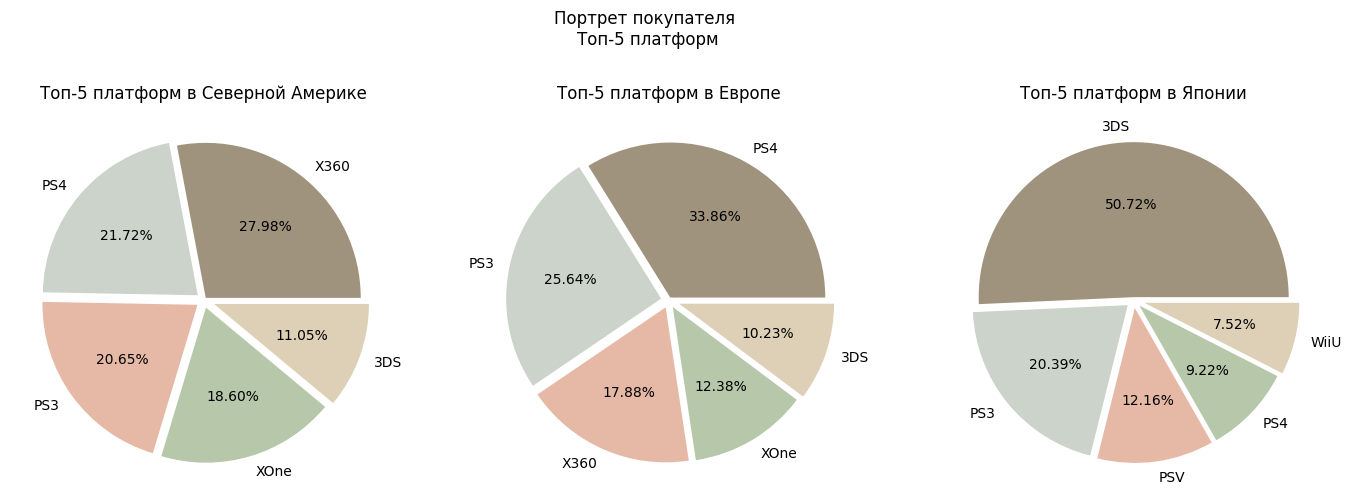

In [26]:
# Определим самые популярные платформы (топ-5) по регионам продаж

# Создадим функцию для определения топ-5 значений заданного параметра по регионам продаж
def get_top_parameter(region_sales, parameter):
    return(data_new
    .pivot_table(index = parameter, values = region_sales, aggfunc = 'sum')
    .sort_values(by = region_sales, ascending = False)
    .head(5)
    )

# Создадим функцию для визуализации
def get_pie(dataset, region_sales):
    plt.pie(dataset[region_sales], 
        autopct = '%1.2f%%', 
        labels = dataset.index, 
        explode = [0.02, 0.05, 0.05, 0.05, 0.07],
        colors = ['#A0937D', '#CCD3CA', '#E6B9A6', '#B6C7AA', '#DED0B6'])
    
# Визуализируем итоги по продажам в регионах в разбивке по топовым платформам

plt.figure(figsize = (17, 6))
plt.suptitle('Портрет покупателя \nТоп-5 платформ')

ax1 = plt.subplot(1, 3, 1)
ax1.set_title('Топ-5 платформ в Северной Америке')
get_pie(get_top_parameter('na_sales', 'platform'), 'na_sales')

              
ax2 = plt.subplot(1, 3, 2)
ax2.set_title('Топ-5 платформ в Европе')
get_pie(get_top_parameter('eu_sales', 'platform'), 'eu_sales')


ax3 = plt.subplot(1, 3, 3)
ax3.set_title('Топ-5 платформ в Японии')
get_pie(get_top_parameter('jp_sales', 'platform'), 'jp_sales')
      
plt.show()

Состав топ-5 популярных платформ в Северной Америке и Европе одинаков, различается лишь последовательность размещения платформ в тройке лидеров: около 28 %  и 1 место в Северной Америке занимает X360 (производитель Microsoft, США), а в Европе - PS4 (Sony, Япония) с 38,8 % . 2 и 3 место в Северной Америке у PS4 и PS3, а в Европе - у PS3 и X360. 

В Японии наблюдается другая особенность - на первом месте с более чем половиной всего рынка - платформа 3DS японской корпорации Nintendo, кроме того в топ-5 присутствует другая платформа того же производителя - WiiU, которая не попала в топ в Европе и Северной Америке и платформа PSV, которая также не попала в топ других регионов.

Если рассматривать страновую принадлежность компаний, которые владеют платформами, лидирующими по продажам в различных регионах, то в Японии 100 % платформ из топ-5 приналежат японским корпорациям Nintendo и Sony. В Северной Америке 46,5 %- американской Microsoft, остальные - продукты корпорации Nintendo и Sony, а в Европе - около 30 % американских платформ, остальные - японские.

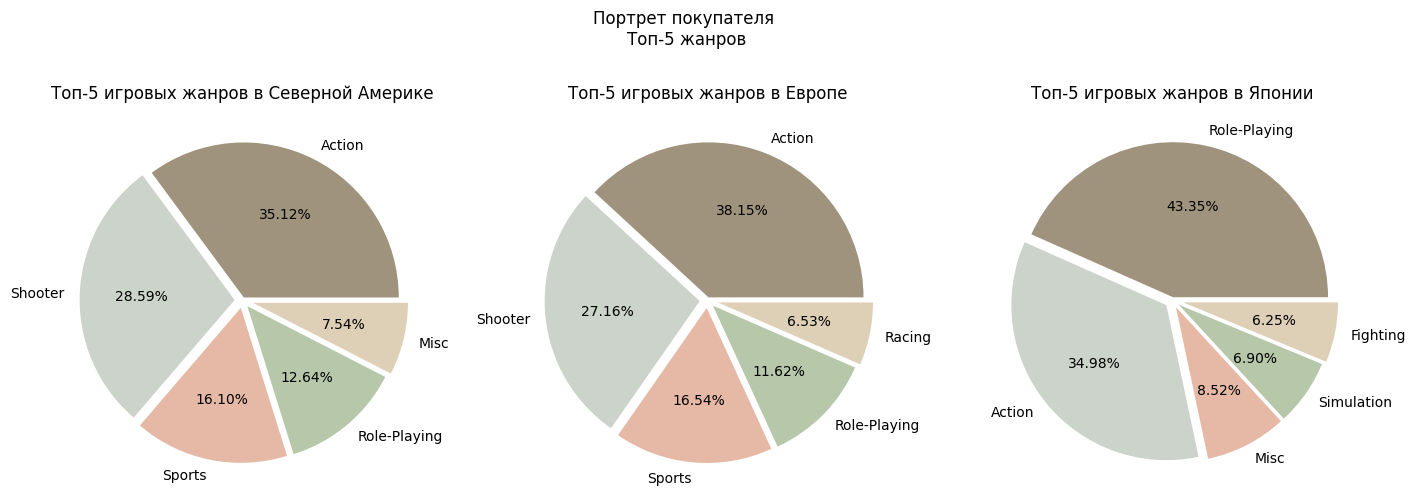

In [27]:
# Определим самые популярные жанры (топ-5) по регионам продаж

   
# Визуализируем итоги по продажам в регионах в разбивке по топовым жанрам

plt.figure(figsize = (17, 6))
plt.suptitle('Портрет покупателя \nТоп-5 жанров')

ax1 = plt.subplot(1, 3, 1)
ax1.set_title('Топ-5 игровых жанров в Северной Америке')
get_pie(get_top_parameter('na_sales', 'genre'), 'na_sales')

              
ax2 = plt.subplot(1, 3, 2)
ax2.set_title('Топ-5 игровых жанров в Европе')
get_pie(get_top_parameter('eu_sales', 'genre'), 'eu_sales')


ax3 = plt.subplot(1, 3, 3)
ax3.set_title('Топ-5 игровых жанров в Японии')
get_pie(get_top_parameter('jp_sales', 'genre'), 'jp_sales')
      
plt.show()

По аналогии с платформами, жанровые предпочтения жителей Северной Америки и Европы очень похожи: в примерно равных долях одинаково распределены первые 4 места из топ-5: 1. экшн 2. шутер 3. спорт 4. ролевые игры. Различие лишь в жанре, замыкающем пятерку лидеров: в Северной Америке - это смешанный жанр, в Европе - гонки.

И вновь по-другому устроен рынок Японии: лидер - ролевые игры, на втором месте - также популярный в Европе и Северной Америке экшн, оставшиеся три места делят смешанные игры, симуляторы и файтинги.

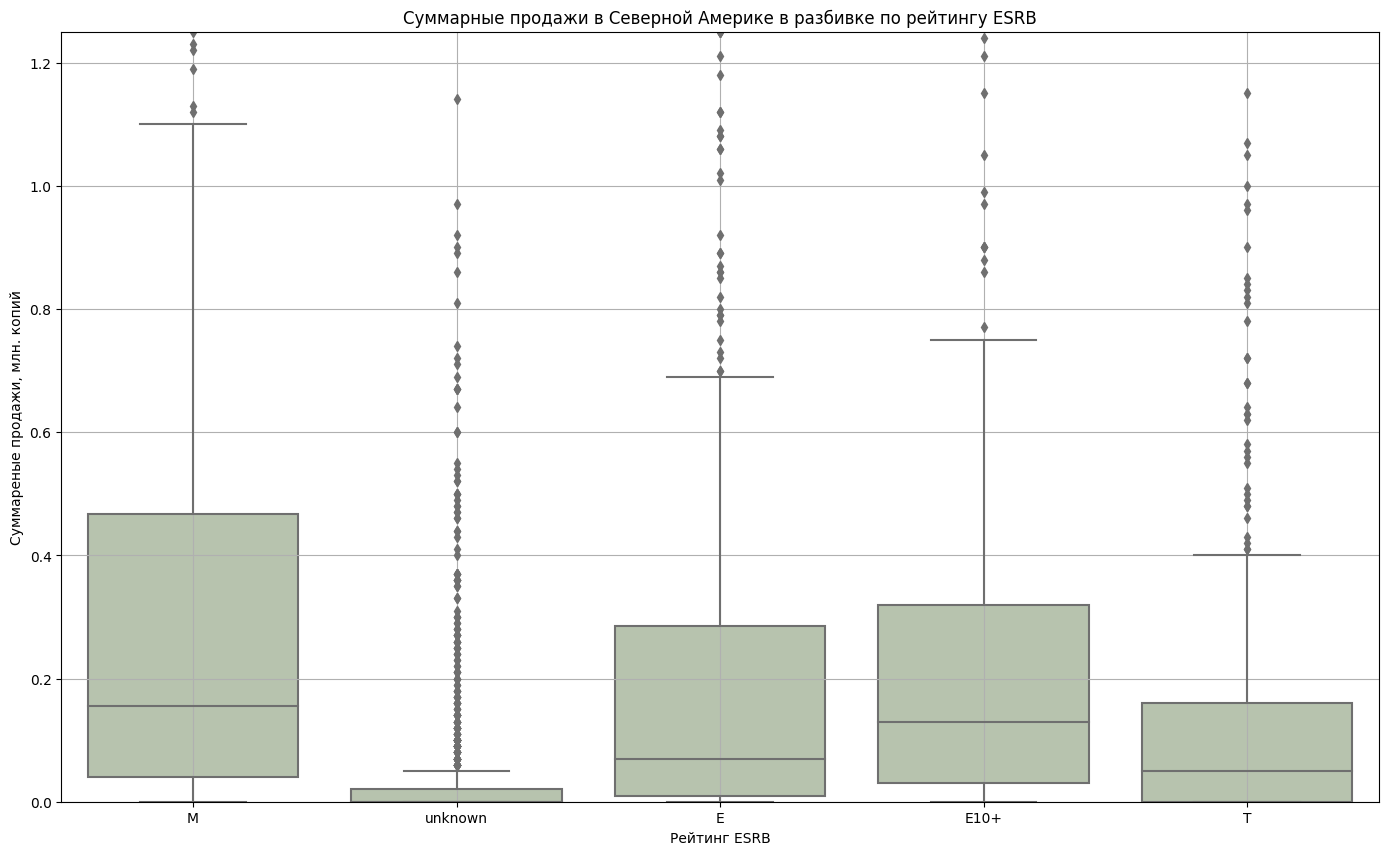

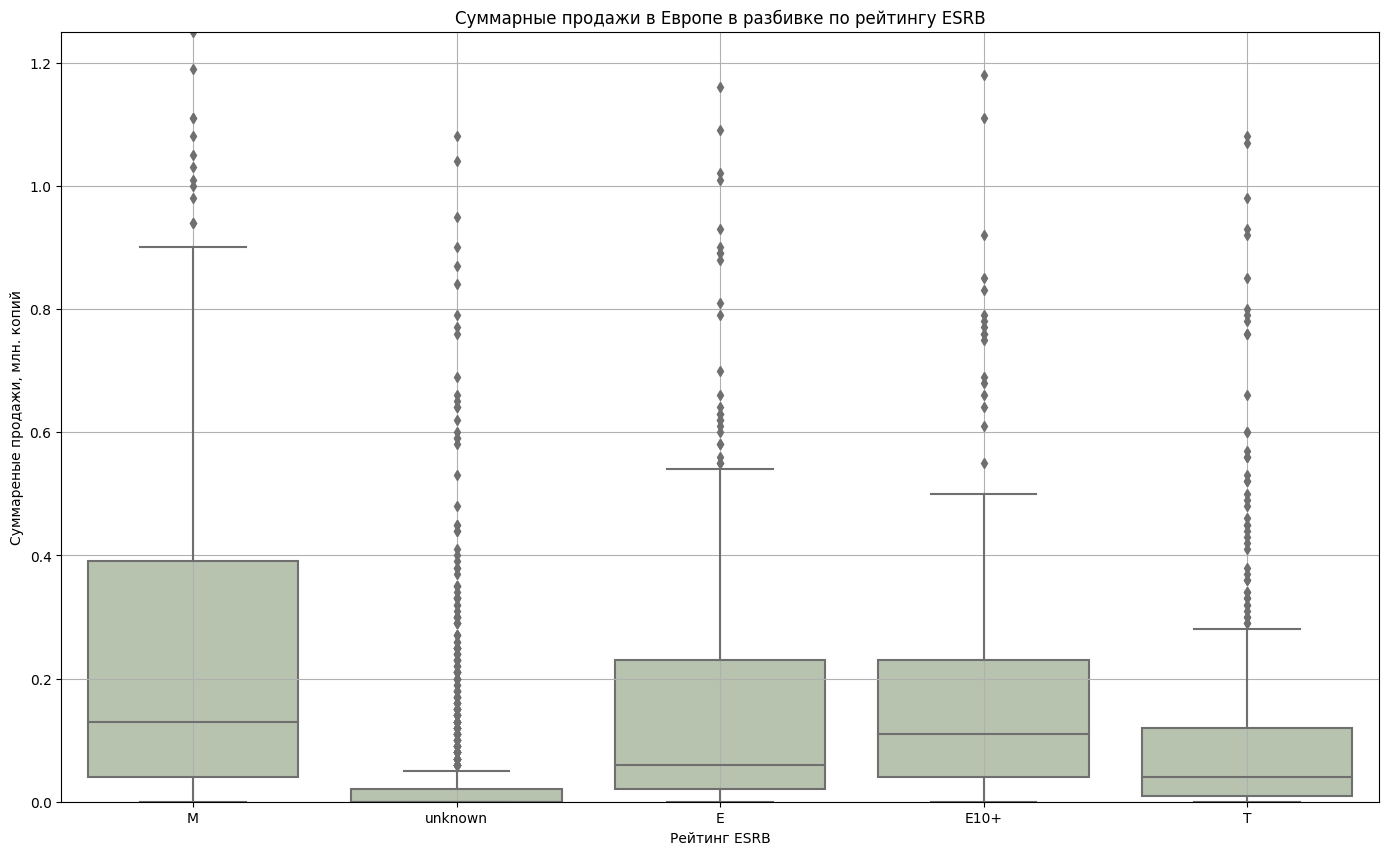

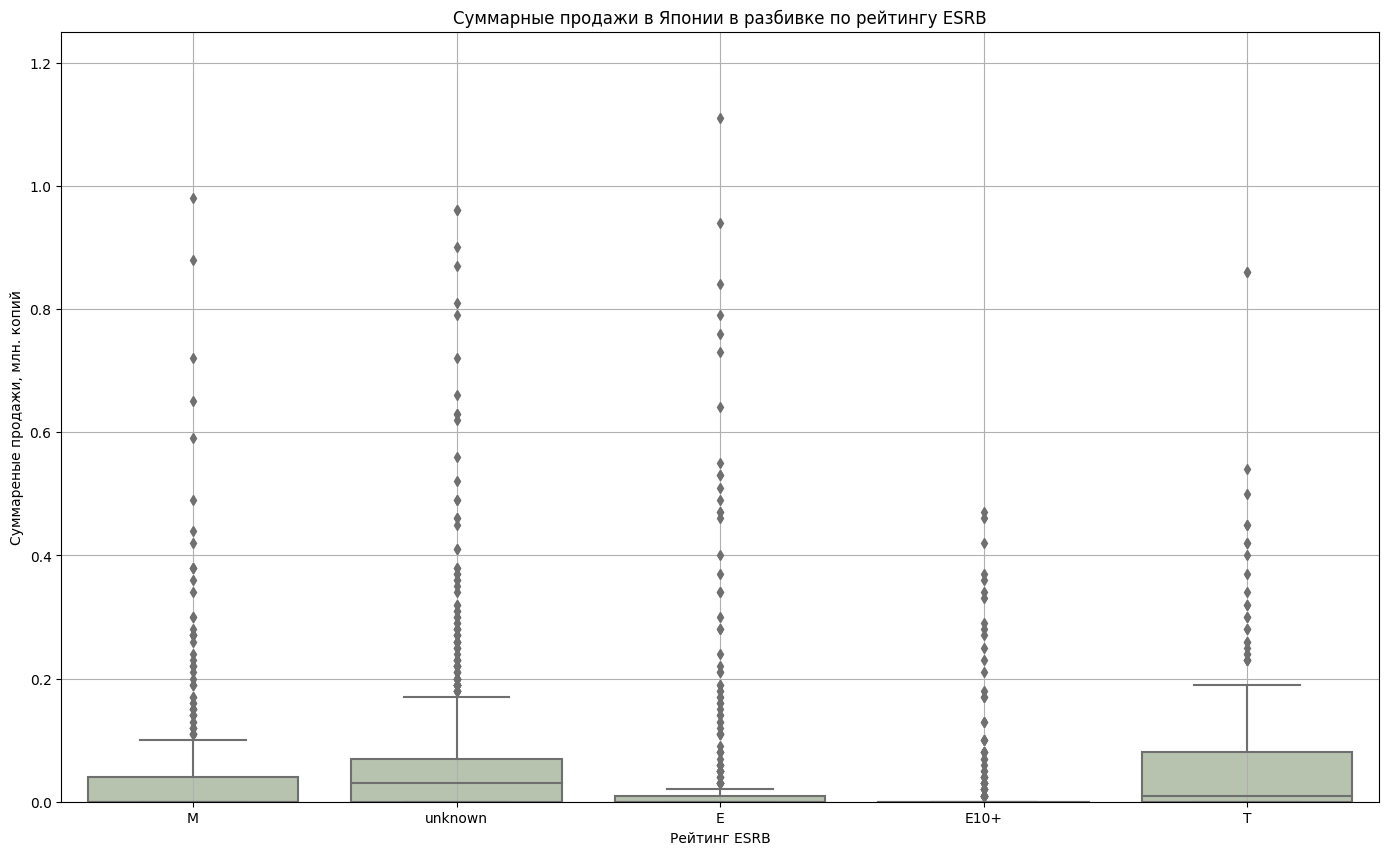

In [28]:
# Проверим, влияет ли рейтинг ESRB на продажи в отдельном регионе, построив распределение продаж игр в разбивке по рейтингам.
# Создадим функцию
def get_boxplt(region_sales):
    plt.figure(figsize = (17, 10))
    esrb_boxplot = sns.boxplot(x = 'rating', y = region_sales, data = data_new, color = '#B6C7AA') 
    esrb_boxplot.set_ylim([0, 1.25])
    plt.grid()
    plt.xlabel('Рейтинг ESRB')
    plt.ylabel('Суммареные продажи, млн. копий')


# Для Северной Америки
get_boxplt('na_sales')
plt.title('Суммарные продажи в Северной Америке в разбивке по рейтингу ESRB')

# Для Европы
get_boxplt('eu_sales')
plt.title('Суммарные продажи в Европе в разбивке по рейтингу ESRB')


# Для Японии
get_boxplt('jp_sales')
plt.title('Суммарные продажи в Японии в разбивке по рейтингу ESRB')

plt.show()

Как и в ситуации с платформами и жанрами, рынок Северной Америки и Европы имеет общие тенденции - наибольшее продажи и наиболее высокое медианное значение показывают игры с рейтингом M (mature - взрослые), которые предназначены для лиц старше 17 лет, второе место занимают детские игры с рейтингом E10+ для лиц старше 10 лет, менее успешны игры для более узкой возрастной группы с рейтингом T (teen - подростки) для лиц старше 13 лет, которым могут уже быть неинтересны детские игры, но взрослые еще под запретом, а также для максимально широкой возрастной группы с рейтингом E (everyone - для всех), самые низкие продажи с большим количеством выбросов у игр без возростного рейтинга. 

Япония показывет иную тенденцию - наибольшие продажи у игр для подростков, на втором месте - игры, у которых отсутствует рейтинг, что отчасти может объясняться, тем, что в Японии существует отдельная организация, которая присваивает возрастные рейтинги играм - CERO,  на третьем месте - игры для взрослых, далее - для всех и совсем небольшие продажи у игр для лиц 10+.

##  Проверка гипотез

**Проверим гипотезу:** cредние пользовательские рейтинги платформ Xbox One и PC одинаковые. Для этого:

**Сформулируем нулевую гипотезу:** cредние пользовательские рейтинги платформ Xbox One и PC равны.

**Сформулируем альтернативную гипотезу:** cредние пользовательские рейтинги платформ Xbox One и PC не равны.

In [29]:
# Вычислим среднее по каждой выборке

data_xone = data_new.query('platform == "XOne"').dropna(subset = ['user_score']) 
data_pc = data_new.query('platform == "PC"').dropna(subset = ['user_score']) 


xbox_one_mean = data_xone['user_score'].mean().round(2)
pc_mean = data_pc['user_score'].mean().round(2)

print(f'Средний пользовательский рейтинг платформы  Xbox One равен {xbox_one_mean}.')
print(f'Средний пользовательский рейтинг платформы  PC равен {pc_mean}.')

# проводим t-test для двух независимых выборок, в качестве альтернативной используем двустороннюю гипотезу
# зададим уровень значимости

alpha = 0.05
results_user_score = st.ttest_ind(data_xone['user_score'], data_pc['user_score'], alternative='two-sided')

print(f'p-value: {results_user_score.pvalue}')

# проверяем p-value
if results_user_score.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

Средний пользовательский рейтинг платформы  Xbox One равен 6.52.
Средний пользовательский рейтинг платформы  PC равен 6.43.
p-value: 0.5535080500643661
Нет оснований отвергнуть нулевую гипотезу


Полученное значение p-value (0.5535080500643661) позволяет не отвергать нулевую гипотезу о том, что средние пользовательские рейтинги Xbox One и PC равны. 


**Проверим гипотезу:** средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные. Для этого:

**Сформулируем нулевую гипотезу:** средние пользовательские рейтинги жанров Action и Sports равны.

**Сформулируем альтернативную гипотезу:** средние пользовательские рейтинги жанров Action и Sports не равны.

In [30]:
# Вычислим среднее по каждой выборке

data_action = data_new.query('genre == "Action"').dropna(subset = ['user_score']) 
data_sports = data_new.query('genre == "Sports"').dropna(subset = ['user_score']) 


action_mean = data_action['user_score'].mean().round(2)
sports_mean = data_sports['user_score'].mean().round(2)

print(f'Средний пользовательский рейтинг игр в жанре Action равен {action_mean}.')
print(f'Средний пользовательский рейтинг игр в жанре Sports равен {sports_mean}.')

# проводим t-test для двух независимых выборок, в качестве альтернативной используем двустороннюю гипотезу
# зададим уровень значимости

alpha = 0.05
results_user_score_genre = st.ttest_ind(data_action['user_score'], data_sports['user_score'], alternative='two-sided')

print(f'p-value: {results_user_score_genre.pvalue}')

# проверяем p-value
if results_user_score_genre.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

Средний пользовательский рейтинг игр в жанре Action равен 6.83.
Средний пользовательский рейтинг игр в жанре Sports равен 5.46.
p-value: 3.716308946093486e-26
Отвергаем нулевую гипотезу


Полученное значение p-value (3.716308946093486e-26) намного меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу в пользу альтернативной - средние пользовательские рейтинги жанров Action и Sports не равны.

**Уточним результаты предыдущего теста, используя одностороннюю гипотезу, чтобы понять, какой из двух жанров имеет большие пользовательские рейтинги.**

**Для этого сформулируем нулевую гипотезу:** средние пользовательские рейтинги жанров Action и Sports равны.

**Сформулируем альтернативную гипотезу:** средние пользовательские рейтинги жанра Action больше рейтингов жанра Sports.

In [31]:
# проводим t-test для двух независимых выборок, в качестве альтернативной используем двустороннюю гипотезу
# зададим уровень значимости

alpha = 0.05
results_user_score_genre = st.ttest_ind(data_action['user_score'], data_sports['user_score'], alternative = 'greater')

print(f'p-value: {results_user_score_genre.pvalue}')

# проверяем p-value
if results_user_score_genre.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value: 1.858154473046743e-26
Отвергаем нулевую гипотезу


Полученное значение p-value (1.858154473046743e-26) намного меньше заданного уровня значимости, поэтому мы можем отвергнуть нулевую гипотезу в пользу альтернативной - средние пользовательские рейтинги жанра Action больше рейтингов жанра Sports.

Мы провели анализ истроических данных о продажах компьютерных игр в период с 2012 по 2016 год, выбрав его в качестве наиболее актуального для прогноза на 2017 год, т.к. именно указанный период показывает не только сопоставимую динамику выпуска новых игр и, соответственно, прогнозируемый уровень конкуренции, но и соответсвует половине десятилетнего жизненного цикла игровой платформы, когда новые платформы приходят на смену старым. Так, например, исследование динамики продаж в разбивке по платформам показало, что, несмотря на общий спад, который наблюдается на рынке по всем платформам, в последние два года наилучшие совокупные результаты показали две платформы, которые вышли в 2013 году - PS4 и XOne. Для подавляющего большинства платформ более 50 % игр проданы в количестве менее 250 тыс. копий, а 75% - менее 750 тыс. копий, при этом значительное число выбросов говорит о том, что у каждой платформы есть игры-звезды, которые показали уровень продаж, существенно превышающий уровень, характерный для большинства игр данной платформы. Вместе с тем в среднем за рассматриваемый период времени суммарный тираж одной игры выше у платформ X360, PS4, XOne, Wii, PS3. 

Анализ трех разных платформ  X360, PS4, 3DS показал отсутствие сильной зависимости как между оценкой критиков и суммарными продажами (коэффициент Пирсона составил 0,32 - 0,41), так и между оценкой пользователй и суммарными продажами (коэффициент Пирсона для двух из трех платформ близок к нулю, для третьей (3DS) составил 0,2). 

Больше всего игр за рассматриваемый период представлены в жанре экшн, далее в порядке убывания с большим отрывом от лидера - ролевые игры, меньше всего представлены стратегии и головоломки. Однако анализ распределения продаж каждой игры в зависимости от жанра показал что, несмотря на их преобладание на рынке, игры в жанре экшн имеют средний уровень прибыльности наравне с ролевыми играми, симуляторами, смешанными жанрами, файтингами и гонками, а лидером по количеству проданных копий ялвяются игры в жанре шутер - медианное значение продаж одной игры в жанре шутер больше, чем у других жанров и близко к значению 500 тыс копий, кроме того шутеры имеют большой межквартильный размах и небольшое количество выбросов в сравнении с другими жанрами, также среди лидеров - спортивные игры и платформеры. 

При планировании рекламной кампании важно понимать тенденции на различных рынках сбыта, чтобы реклама попадала в целевую аудиторию, для этого мы оценили портрет пользователя разных регионов и выявили, что предпочтения пользователей в Северной Америке и Европе во многом схожи, а рынок Японии имеет свою специфику. Так, топ-5 наиболее популярных платформ в Северной Америке и Европе имеет одинаковый состав, но разное распределние внитри рейтинга - перые два места и около половины рынка в Северной Америке делят X360(Microsoft, США) и PS4(Sony, Япония), а в Европе - PS4 и PS3 (Sony, Япония). В Японии же видим, что все платформы из топ-5 принадлежат японским корпорациям и более 50% занимает платформа 3DS (Nintendo), а также присутствуют платформы, которые не попали в топ других регионов - WiiU и PSV. 

Жанровые предпочтения пользователей Северной Америки и Европы также очень похожи - 4 из 5 топовых жанра совпадают и распределены в аналогичных долях: 1. экшн 2. шутер 3. спорт 4. ролевые игры, а замыкает пятерку лидеров в Северной Америке - смешанный жанр, в Европе - гонки. Японская аудитория отдает предпочтение ролевым играм, на втором месте - также популярный в Европе и Северной Америке экшн, оставшиеся три места делят смешанные игры, симуляторы и файтинги.

Кроме того, рынок Северной Америки и Европы имеет общие тенденции и с точки зрения соотвеношения возрастного рейтинга с продажами - наибольшее продажи и наиболее высокое медианное значение показывают игры с рейтингом M (mature - взрослые), которые предназначены для лиц старше 17 лет, второе место занимают детские игры с рейтингом E10+ для лиц старше 10 лет, менее успешны игры для более узкой возрастной группы с рейтингом T (teen - подростки) для лиц старше 13 лет, которым могут уже быть неинтересны детские игры, но взрослые еще под запретом, а также для максимально широкой возрастной группы с рейтингом E (everyone - для всех), самые низкие продажи с большим количеством выбросов у игр без возростного рейтинга.

Япония показывет иную тенденцию - наибольшие продажи у игр для подростков, на втором месте - игры, у которых отсутствует рейтинг, что отчасти может объясняться, тем, что в Японии существует отдельная организация, которая присваивает возрастные рейтинги играм - CERO, на третьем месте - игры для взрослых, далее - для всех и совсем небольшие продажи у игр для лиц 10+.